In [ ]:
import numpy as np
from scipy.constants import speed_of_light as c
from scipy.constants import pi
import matplotlib.pyplot as plt

In [ ]:
def nextPowerOf2(n):
    count = 0;
 
    # First n in the below
    # condition is for the
    # case where n is 0
    if (n and not(n & (n - 1))):
        return n
     
    while( n != 0):
        n >>= 1
        count += 1
     
    return 1 << count;

def calculate_phi(W, K, lambda2, times=4):

        l2 = lambda2

        l2_max = l2[-1]
        l2_min = l2[0]

        l2_ref = (1./K) * np.sum(W * lambda2)

        delta_l2 = np.abs(l2[1] - l2[0])

        delta_phi_fwhm = 2.0 * np.sqrt(3.0) / \
            (l2_max - l2_min)  # FWHM of the FPSF
        delta_phi_theo = pi / l2_min

        delta_phi = min(delta_phi_fwhm, delta_phi_theo)

        phi_max = np.sqrt(3) / (delta_l2)

        phi_r = delta_phi / times

        temp = np.int(np.floor(2 * phi_max / phi_r))
        n = int(temp - np.mod(temp, 32))

        phi_r = 2 * phi_max / n

        phi = phi_r * np.arange(-(n / 2), (n / 2), 1)

        return l2, l2_ref, phi, phi_r
    

def calculate_W_K(l2, sigma=np.array([])):

        if not len(sigma):
            W = np.ones(len(l2))
        else:
            W = 1.0 /(sigma**2)

        K = np.sum(W)

        return W, K
    
def nu_to_l2(nu):
        lambda2 = (c/nu)**2
        return lambda2[::-1]    

In [ ]:
sigmas_file = "sigmas.npy"
freqs_file = "freqs.npy"
p_file = "polarized_emission.npy"

nu = np.load(freqs_file)
sigmas = np.load(sigmas_file)
P = np.load(p_file)

lambda2 = nu_to_l2(nu)
W,K = calculate_W_K(lambda2, sigmas)
lambda2, l2_ref, phi, phi_r = calculate_phi(W, K, lambda2)

m = len(lambda2)
n = len(phi)
l_min = lambda2[0]
l_max = lambda2[-1]
delta_l2 = np.abs(lambda2[1] - lambda2[0])
#print(lambda2)

<ipython-input-2-21aa2483892a>:37: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  temp = np.int(np.floor(2 * phi_max / phi_r))


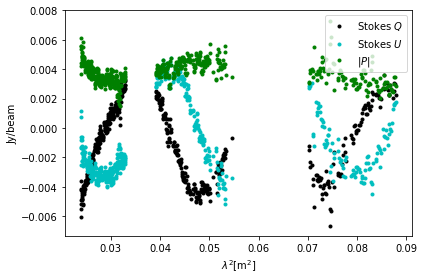

In [ ]:
plt.plot(lambda2, P.real, 'k.', label=r"Stokes $Q$")
plt.plot(lambda2, P.imag, 'c.', label=r"Stokes $U$")
plt.plot(lambda2, np.abs(P), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
plt.legend(loc='upper right')
plt.tight_layout()

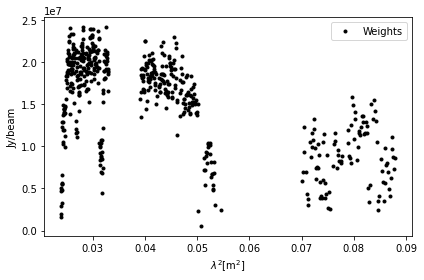

In [ ]:
plt.plot(lambda2, W, 'k.', label=r"Weights")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
plt.legend(loc='upper right')
plt.tight_layout()

In [ ]:
# Gridding procedure
delta_l2 = pi/(4*n*phi_r)
#Preparing grid
l2_grid = np.arange(start=0, stop=l_max, step=delta_l2)
m_grid = len(l2_grid)

P_grid_real = np.zeros(m_grid)
P_grid_imag = np.zeros(m_grid)
W_grid = np.zeros(m_grid)

print(m_grid)
print(delta_l2)

15742
5.586005587559081e-06


In [ ]:
for i in range(0,m):
    l2_grid_pos = int(np.floor(lambda2[i]/delta_l2))
    if(l2_grid_pos < m_grid):
       P_grid_real[l2_grid_pos] += W[i] * P[i].real
       P_grid_imag[l2_grid_pos] += W[i] * P[i].imag
       W_grid[l2_grid_pos] += W[i]
        
valid_idx = np.where(W_grid > 0.0)   
#invalid_idx = np.where(W_grid <= 0.0)

P_grid_real[valid_idx] /= W_grid[valid_idx]
P_grid_imag[valid_idx] /= W_grid[valid_idx]

P_grid = P_grid_real + 1j * P_grid_imag
K_grid = 1/np.sum(W_grid)

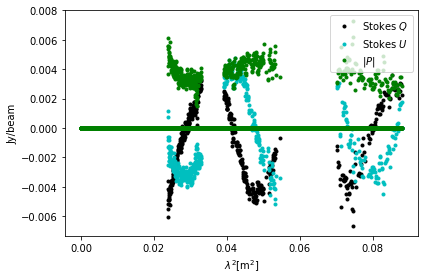

In [ ]:
plt.plot(l2_grid, P_grid.real, 'k.', label=r"Stokes $Q$")
plt.plot(l2_grid, P_grid.imag, 'c.', label=r"Stokes $U$")
plt.plot(l2_grid, np.abs(P_grid), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
plt.legend(loc='upper right')
plt.tight_layout()

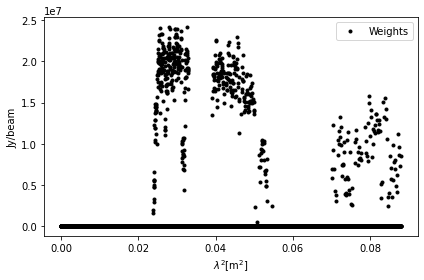

In [ ]:
plt.plot(l2_grid, W_grid, 'k.', label=r"Weights")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
plt.legend(loc='upper right')
plt.tight_layout()

15742


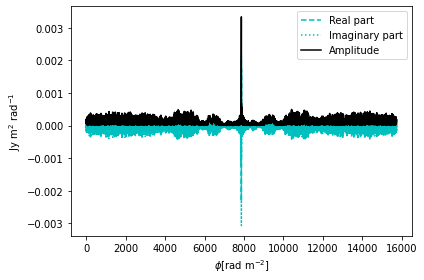

In [ ]:
F_grid = np.fft.ifftshift(np.fft.ifft(W_grid*P_grid))
F_grid = F_grid * len(F_grid) / K
print(len(F_grid))


plt.plot(F_grid.real, 'c--', label=r"Real part")
plt.plot(F_grid.imag, 'c:', label=r"Imaginary part")
plt.plot(np.abs(F_grid), 'k-', label=r"Amplitude")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy m$^2$ rad$^{-1}$')
plt.legend(loc='upper right')
#plt.xlim([0, 1000])
plt.tight_layout()